# Home Cage Dopamine Analysis

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

from hc_extension import *
from Hab_Dishab.hd_extension import get_trial_dataframes, create_metadata_dataframe, create_da_metrics_dataframe, plot_peak_for_subsequent_investigations_custom

In [2]:
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\nac"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\nac_csvs"
# brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\mpfc"
csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\mpfc_csvs"
brain_region = '#FFAF00'

In [3]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\mpfc\pp1-250120-094415\Notes.txt
read from t=0s to t=1864.97s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\mpfc\pp2-250121-123301\Notes.txt
read from t=0s to t=1852.76s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\mpfc\pp3-250121-055222\Notes.txt
read from t=0s to t=1858.76s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\mpfc\pp4-250121-065035\Notes.txt
read from t=0s to t=1876.76s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\mpfc\pp5-250121-110144\Notes.txt
read from t=0s to t=1895.67s
Found Synapse note file: C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined\Home_Cage\mpfc\pp6-250121-114116\Notes.txt
read from t=0s to t=1861.06s
Found Synapse no

In [4]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions, first_only=True)

Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...


### Peak standard z-score

In [5]:
# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  use_adaptive=False, 
                                  allow_bout_extension=False,
                                  mode='standard')

Computing DA metrics for pp1-250120-094415 ...
Computing DA metrics for pp2-250121-123301 ...
Computing DA metrics for pp3-250121-055222 ...
Computing DA metrics for pp4-250121-065035 ...
Computing DA metrics for pp5-250121-110144 ...
Computing DA metrics for pp6-250121-114116 ...
Computing DA metrics for pp7-250121-134131 ...
Computing DA metrics for pp8-250121-142227 ...


In [6]:
exp_da_dict = get_trial_dataframes(experiment)

In [7]:
desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']
da_metadata_df = create_da_metrics_dataframe(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

In [8]:
da_metadata_df.head(6)

,Subject,Bout,Behavior,AUC,Max Peak,Mean Z-score
0,pp1,Short_Term-1,Investigation,9.122118,4.327607,3.258804
1,pp1,Novel-1,Investigation,3.828178,1.564405,0.671690
2,pp1,Short_Term-2,Investigation,3.722572,2.955040,0.288612
3,pp1,Long_Term-1,Investigation,0.114313,0.928633,0.033798
4,pp2,Short_Term-1,Investigation,0.000000,0.000000,0.000000
5,pp2,Novel-1,Investigation,-0.142931,1.088306,-0.034736


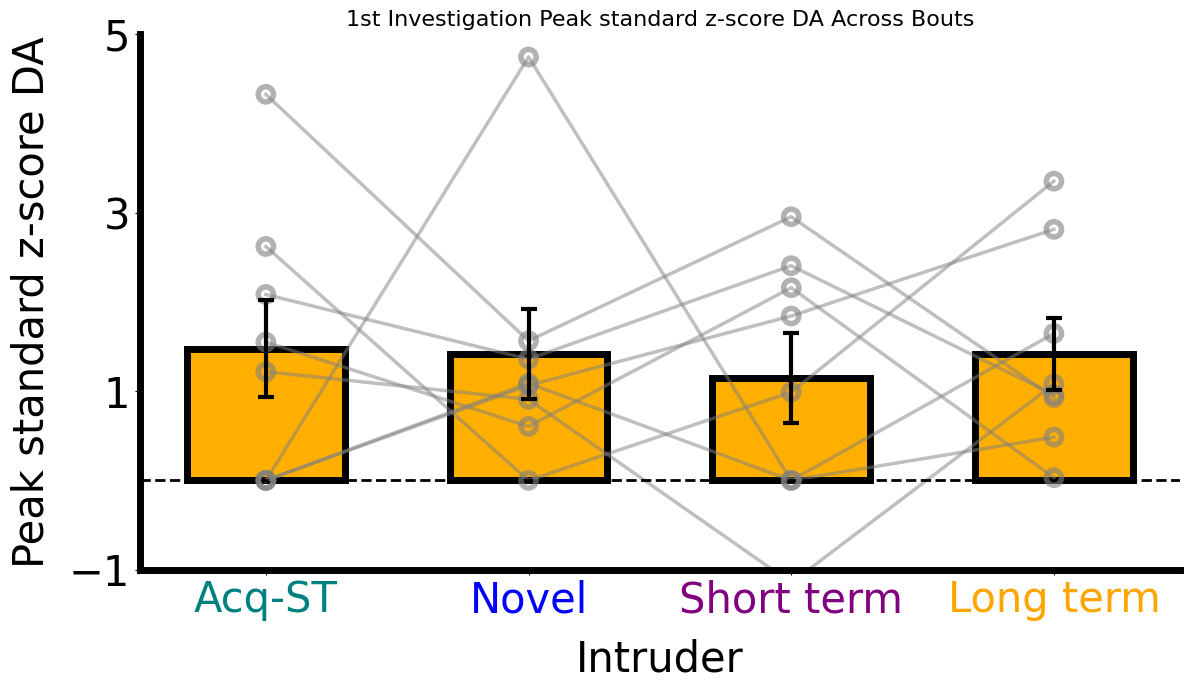

In [17]:
# Average Bout Duration Across Bouts
hc_plot_behavior_times_across_bouts_gray(
    metadata_df=da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title="1st Investigation Peak standard z-score DA Across Bouts",
    xlabel="Intruder",
    ylabel="Peak standard z-score DA",
    custom_xtick_labels=["Acq-ST", "Novel", "Short term", "Long term"],
    bout_order=['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1'],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-1, 5),
    bar_color=brain_region,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=False,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_C1-3_Peak_Across_Bouts.png"
)

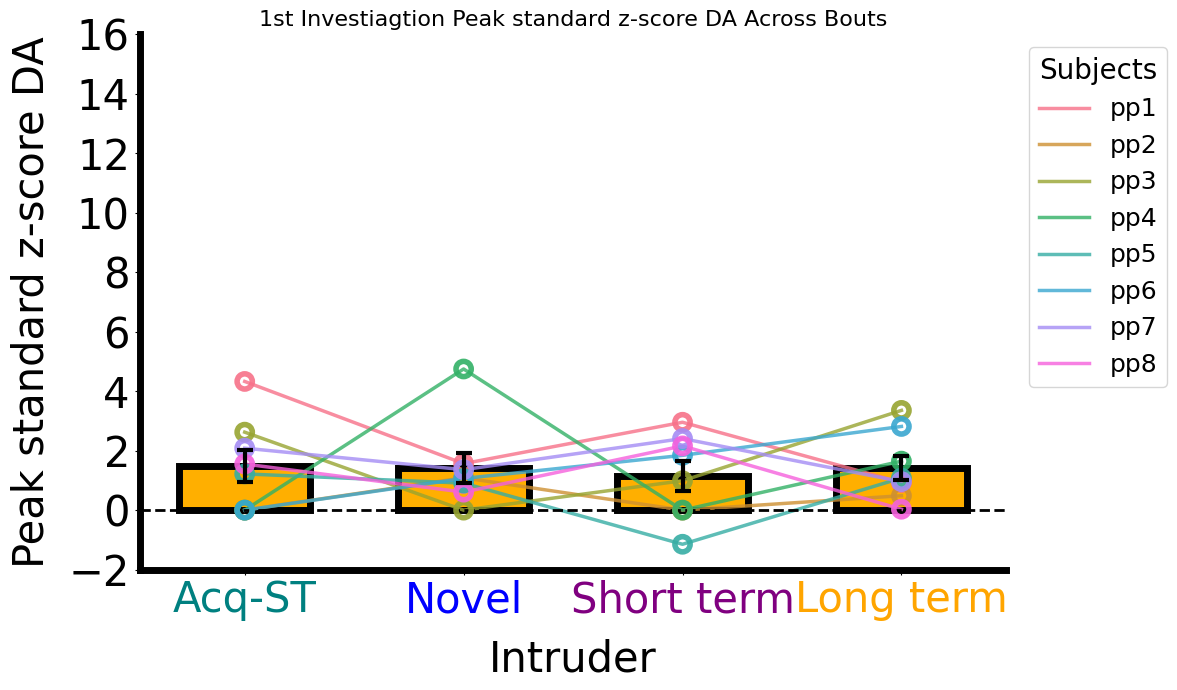

In [10]:
# Average Bout Duration Across Bouts
plot_behavior_times_across_bouts_colored(
    metadata_df=da_metadata_df,
    y_col="Max Peak",
    behavior="Investigation",
    title="1st Investiagtion Peak standard z-score DA Across Bouts",
    xlabel="Intruder",
    ylabel="Peak standard z-score DA",
    custom_xtick_labels=["Acq-ST", "Novel", "Short term", "Long term"],
    bout_order=['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1'],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-2, 15),
    bar_color=brain_region,
    yticks_increment=2,
    figsize=(12,7),
    pad_inches=0.1,
    save=False,
    save_name=r"Hab_Dishab_Plots\mPFC_DA\mPFC_C1-3_Peak_Across_Bouts_WIDENTITIES.png"
)

In [11]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, #otal_avg_bout_duration
                                  use_adaptive=False, 
                                  allow_bout_extension=False,
                                  mode='standard')

Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Computing DA metrics for pp1-250120-094415 ...
Computing DA metrics for pp2-250121-123301 ...
Computing DA metrics for pp3-250121-055222 ...
Computing DA metrics for pp4-250121-065035 ...
Computing DA metrics for pp5-250121-110144 ...
Computing DA metrics for pp6-250121-114116 ...
Computing DA metrics for pp7-250121-134131 ...
Computing DA metrics for pp8-250121-142227 ...


In [12]:
exp_da_dict = get_trial_dataframes(experiment)

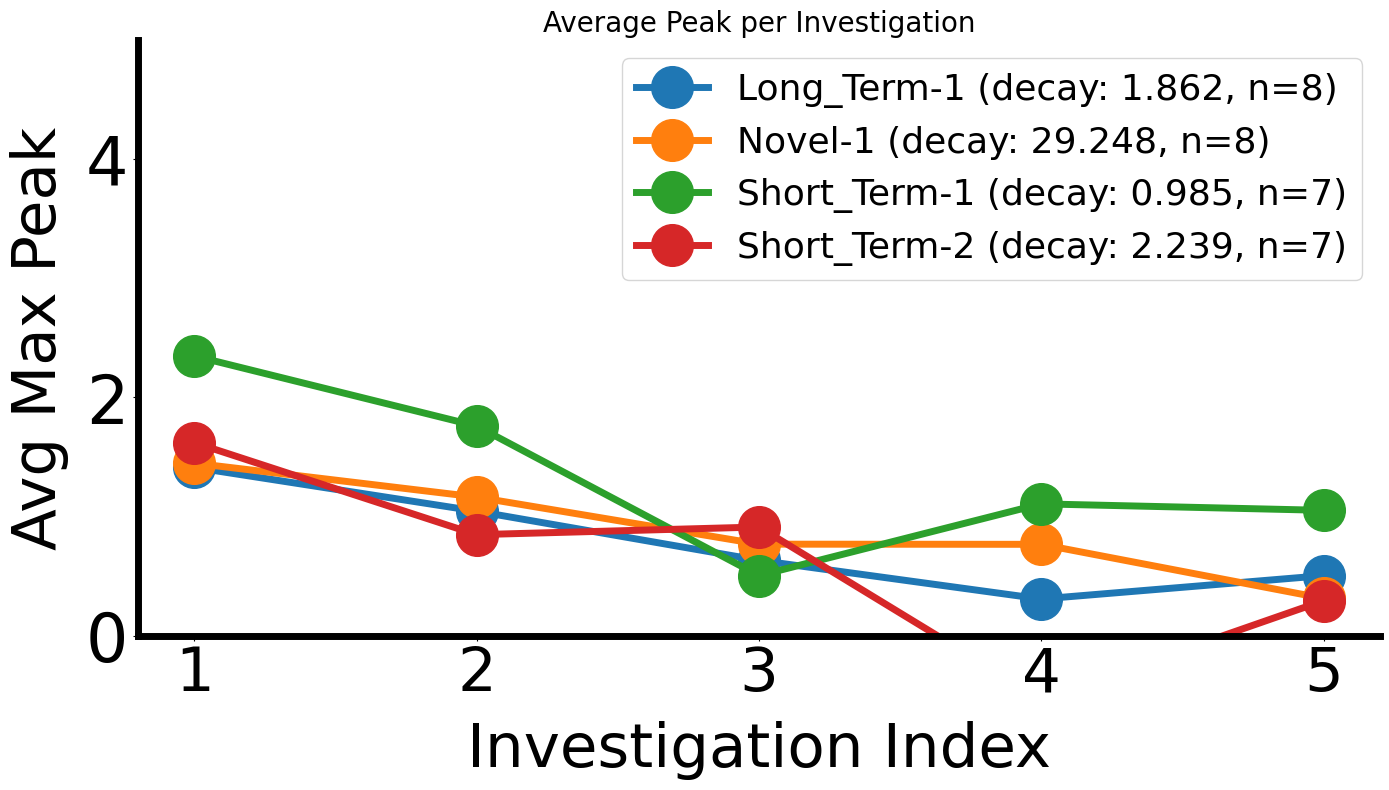


=== Computed Metric (DECAY): ===
Bout: Long_Term-1, decay = 1.862
Bout: Novel-1, decay = 29.248
Bout: Short_Term-1, decay = 0.985
Bout: Short_Term-2, decay = 2.239


In [13]:
# Suppose exp_da_dict = {"nn8": df_nn8, "nn3": df_nn3, ...}

# Plot the first 3 investigations for bouts s1-1 and s1-2:
df_final = plot_peak_for_subsequent_investigations_custom(
    exp_da_dict,
    selected_bouts=['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1'],
    n_subsequent_investigations=5,
    peak_col="Max Peak",
    metric_type='decay', 
    ylim=(0, 5)
)


In [14]:
df_final

,Bout,InvestigationIndex,SubjectCount,AvgPeak
0,Long_Term-1,1,8,1.412448
1,Long_Term-1,2,8,1.045130
2,Long_Term-1,3,8,0.632423
3,Long_Term-1,4,8,0.307637
4,Long_Term-1,5,7,0.503961
5,Novel-1,1,8,1.448128
6,Novel-1,2,8,1.163687
7,Novel-1,3,8,0.768170
8,Novel-1,4,8,0.766707
9,Novel-1,5,8,0.312563
